In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [ ]:
df_initial = pd.read_csv('./data.csv',encoding='latin1',dtype={'CustomerID': str,'InvoiceID': str})
df_initial['InvoiceDate'] = pd.to_datetime(df_initial['InvoiceDate'])
print('Dataframe dimensions:', df_initial.shape)

tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.rename(index={0:'null values (%)'}))
print(tab_info)

In [ ]:
df_initial.head()

In [ ]:
# Remove entries for customer ID NULL
df_initial.dropna(axis = 0, subset = ['CustomerID'], inplace = True)
print('Dataframe dimensions:', df_initial.shape)

tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.rename(index={0:'null values (%)'}))
print(tab_info)

In [ ]:
df_initial.drop_duplicates(inplace = True)

In [ ]:
print('Dataframe dimensions:', df_initial.shape)

In [ ]:
country_to_index = {}
count=0
countries = df_initial["Country"].to_numpy()
for i in range(countries.shape[0]):
    if countries[i] not in country_to_index:
        country_to_index[countries[i]] = count
        count+=1
print(count)
print(country_to_index)

In [ ]:
df_initial = df_initial.drop("Country", 1)

In [ ]:
df_initial.head()

In [ ]:
for i in range(countries.shape[0]):
    countries[i] = country_to_index[countries[i]]
df_initial["CountryID"] = countries
df_initial.tail()

In [ ]:
df_phase2 = df_initial
df_phase2

In [ ]:
pd.DataFrame([{'products': len(df_initial['StockCode'].value_counts()),    
               'transactions': len(df_initial['InvoiceNo'].value_counts()),
               'customers': len(df_initial['CustomerID'].value_counts()),  
              }], columns = ['products', 'transactions', 'customers'], index = ['quantity'])

In [ ]:
# Grouping Rows if they belong to same invoice no and customer id
temp = df_phase2.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket[:10].sort_values('CustomerID')

In [ ]:
df_cleaned = df_phase2.copy(deep = True)
df_cleaned['QuantityCanceled'] = 0

entry_to_remove = [] ; doubtfull_entry = []

for index, col in  df_phase2.iterrows():
    if (col['Quantity'] > 0) or col['Description'] == 'Discount': continue        
    df_test = df_phase2[(df_phase2['CustomerID'] == col['CustomerID']) &
                         (df_phase2['StockCode']  == col['StockCode']) & 
                         (df_phase2['InvoiceDate'] < col['InvoiceDate']) & 
                         (df_phase2['Quantity']   > 0)].copy()

    # Cancelation WITHOUT counterpart
    if (df_test.shape[0] == 0): 
        doubtfull_entry.append(index)

    # Cancelation WITH a counterpart
    elif (df_test.shape[0] == 1): 
        index_order = df_test.index[0]
        df_cleaned.loc[index_order, 'QuantityCanceled'] = -col['Quantity']
        entry_to_remove.append(index)        

    # Various counterparts exist in orders: we delete the last one
    elif (df_test.shape[0] > 1): 
        df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']: continue
            df_cleaned.loc[ind, 'QuantityCanceled'] = -col['Quantity']
            entry_to_remove.append(index) 
            break        
    print('outside for loop',index)    

In [ ]:
df_phase3 = df_cleaned

In [ ]:
df_phase3["TotalPrice"] = df_phase3["UnitPrice"]*(df_phase3["Quantity"] - df_phase3["QuantityCanceled"])
df_phase3

In [ ]:
temp = df_phase3.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice':'Basket Price'})
basket_price = basket_price[basket_price["Basket Price"]>0]
basket_price.head()

In [ ]:
df_phase4 = pd.read_csv('basket_price.csv', encoding = 'latin1')
df_phase4

In [ ]:
df_phase3 = pd.read_csv('df_phase3.csv', encoding = 'latin1', dtype={'CustomerID': str,'InvoiceID': str})
df_phase3

In [ ]:
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
lem = WordNetLemmatizer()

In [ ]:
root_freq = {}
desc_to_roots = {}
root_to_index = {}
count = 0

def is_noun(pos):
    if pos[:2] == 'NN':
        return True
    return False


for desc in df_phase3["Description"]:
    if pd.isnull(desc):
        continue 
    desc = desc.lower()
    tokens = nltk.word_tokenize(desc)
    nouns = [word for (word, pos) in nltk.pos_tag(tokens) if is_noun(pos)] 
    vis = {}
    temp = []
    for noun in nouns:
        noun = noun.lower()
        root = lem.lemmatize(noun)
        if root not in root_freq:
            root_freq[root] = 1
            vis[root] = 1
            temp.append(root)
            root_to_index[root] = count 
            count += 1
        elif root not in vis:
            root_freq[root] += 1
            vis[root] = 1
            temp.append(root)
    desc_to_roots[desc] = temp

print(root_freq)

In [ ]:
print(root_to_index)

In [ ]:
print(desc_to_roots)

In [47]:
threshold = 500
print(len(root_freq))
top_roots = {key:val for key, val in root_freq.items() if val >= threshold}
print(len(top_roots))

1506
374


In [ ]:
c = 0
pop_root_to_index = {}
for key, val in top_roots.items():
    pop_root_to_index[key] = c 
    c += 1
print(pop_root_to_index)

In [ ]:
lis = df_phase3.UnitPrice.value_counts()
print(lis)

In [ ]:
list_products = df_phase3["Description"].unique()

In [52]:
products_np = []
mean_prices = []
count_cat = [0 for _ in range(6)]
for i,desc in enumerate(list_products):
    # print(i)
    # print(df_phase3[df_phase3["Description"] == desc]["StockCode"])
    temp = [df_phase3[df_phase3["Description"] == desc]["StockCode"].iloc[0], desc]
    roots = desc_to_roots[desc.lower()]
    t = [0 for i in range(len(top_roots))]
    for root in roots:
        if root in top_roots:
            index = pop_root_to_index[root]
            t[index] = 1
    temp.extend(t)
    mean_price = df_phase3[df_phase3["Description"] == desc]["UnitPrice"].mean()
    prod_cat = 0

    if mean_price < 1:
        prod_cat = 0
    elif mean_price < 2:
        prod_cat = 1
    elif mean_price < 3:
        prod_cat = 2
    elif mean_price < 5:
        prod_cat = 3
    elif mean_price < 10:
        prod_cat = 4
    else:
        prod_cat = 5

    cat_list = [0 for _ in range(6)]
    cat_list[prod_cat] = 1
    temp.extend(cat_list)
    # mean_prices.append(mean_price)
    count_cat[prod_cat]+=1
    temp = np.array(temp)
    # print(temp.shape)
    products_np.append(temp)

In [ ]:
bins = np.arange(-100, 100, 1) # fixed bin size

plt.xlim([min(mean_prices)-5, 20])

plt.hist(mean_prices, bins=bins, alpha=0.5)
plt.show()

In [53]:
count_cat = np.array(count_cat)
for i in range(6):
    print(count_cat[i]/np.sum(count_cat) * 100, "%")

24.69199178644764 %
26.07802874743326 %
17.2741273100616 %
15.708418891170432 %
12.217659137577003 %
4.029774127310062 %


In [54]:
print(products_np[20])

['48187' 'DOORMAT NEW ENGLAND' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0' '1' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' 

In [56]:
products_np = np.array(products_np)
print(products_np.shape)

(3896, 382)


In [64]:
cols = ["StockCode","Description"]
for i in range(374):
    cols.append("root-"+str(i+1))
for i in range(6):
    cols.append("priceRange-"+str(i+1))
df_products = pd.DataFrame(products_np,columns = cols)
df_products.to_csv("df_products.csv")

importing Jupyter notebook from driver.ipynb
importing Jupyter notebook from kmeans.ipynb
importing Jupyter notebook from kmeanspp.ipynb
[array([4, 4]), array([-2, -2]), array([8, 8])]
[[ 0.8  1.   1. ]
 [ 0.8 -1.   2. ]
 [-1.   1.2  3. ]
 [ 1.  -1.2  2. ]
 [-0.8 -1.   0. ]
 [ 1.   0.8  1. ]
 [-1.  -1.2  0. ]
 [ 1.   1.2  1. ]
 [ 1.  -0.8  2. ]
 [ 1.   1.   1. ]
 [ 1.  -1.   2. ]
 [-1.   0.8  3. ]
 [-1.  -0.8  0. ]
 [-1.  -1.   0. ]
 [-0.8  1.   3. ]
 [-1.   1.   3. ]]
[array([-0.95, -1.  ]), array([0.95, 1.  ]), array([ 0.95, -1.  ]), array([-0.95,  1.  ])]


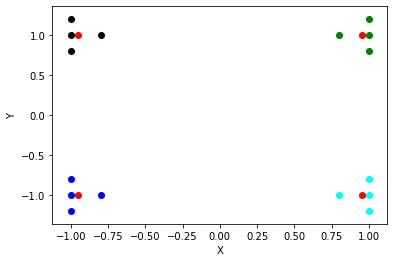

FileNotFoundError: [Errno 2] File processed_data.csv does not exist: 'processed_data.csv'

In [62]:
import import_ipynb
from driver import plotGraphs



In [63]:
plotGraphs(products_np[:, 2:],10)

NameError: name 'plotGraphs' is not defined